### FairFace Dataset as pseudo-labeling, evaluated on All-Age-Face Data (AAF - Mostly Asian)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from pathlib import Path
from timm import create_model
!pip install torchmetrics
from torchmetrics.classification import BinaryAccuracy, Accuracy

tqdm.pandas()

base_img = Path('../Pseudo-Labeling/FairFace')

train_df = pd.read_csv('../Pseudo-Labeling/FairFace/train_labels.csv')
val_df = pd.read_csv('../Pseudo-Labeling/FairFace/val_labels.csv')

train_df.drop(columns=['service_test'], inplace=True)
val_df.drop(columns=['service_test'], inplace=True)

train_df['file'] = train_df['file'].progress_map(lambda x: base_img / x)
val_df['file'] = val_df['file'].progress_map(lambda x: base_img / x)

train_df['age'] = train_df['age'].astype('category')
train_df['age_code'] = train_df['age'].cat.codes

age_map = dict(zip(train_df['age'].cat.categories, range(len(train_df['age'].cat.categories))))
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x: gender_map[x])
val_df['age_code'] = val_df['age'].progress_map(lambda x: age_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x: gender_map[x])

# Encoding race categories
train_df['race'] = train_df['race'].astype('category')
train_df['race_code'] = train_df['race'].cat.codes

race_map = dict(zip(train_df['race'].cat.categories, range(len(train_df['race'].cat.categories))))
val_df['race_code'] = val_df['race'].progress_map(lambda x: race_map[x])



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [3]:

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### FairFace Data Retrieval


### Imports

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from pathlib import Path
from timm import create_model
from torchmetrics.classification import BinaryAccuracy, Accuracy
import os
tqdm.pandas()

In [4]:
import shutil

# Define directories for FairFace dataset
dataset_path_orig = Path("FairFace")
dataset_path_dest = Path("./fairface_race_dataset")
os.makedirs(dataset_path_dest, exist_ok=True)

dataset_path_training = dataset_path_dest / "Training"
dataset_path_validation = dataset_path_dest / "Validation"
os.makedirs(dataset_path_training, exist_ok=True)
os.makedirs(dataset_path_validation, exist_ok=True)

dataset_path_training_female = dataset_path_training / "female"
dataset_path_training_male = dataset_path_training / "male"
dataset_path_validation_female = dataset_path_validation / "female"
dataset_path_validation_male = dataset_path_validation / "male"
os.makedirs(dataset_path_training_female, exist_ok=True)
os.makedirs(dataset_path_training_male, exist_ok=True)
os.makedirs(dataset_path_validation_female, exist_ok=True)
os.makedirs(dataset_path_validation_male, exist_ok=True)


In [5]:
# Filter FairFace dataset by gender and age
for index, row in train_df.iterrows():
    img_path_orig = row['file']
    gender = row['gender_code']

    if gender == 1:  # Female
        img_path_dest = dataset_path_training_female / img_path_orig.name
    elif gender == 0:  # Male
        img_path_dest = dataset_path_training_male / img_path_orig.name
    else:
        print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))

for index, row in val_df.iterrows():
    img_path_orig = row['file']
    gender = row['gender_code']

    if gender == 1:  # Female
        img_path_dest = dataset_path_validation_female / img_path_orig.name
    elif gender == 0:  # Male
        img_path_dest = dataset_path_validation_male / img_path_orig.name
    else:
        print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))

In [6]:
age_map, gender_map, race_map

({'0-2': 0,
  '10-19': 1,
  '20-29': 2,
  '3-9': 3,
  '30-39': 4,
  '40-49': 5,
  '50-59': 6,
  '60-69': 7,
  'more than 70': 8},
 {'Male': 0, 'Female': 1},
 {'Black': 0,
  'East Asian': 1,
  'Indian': 2,
  'Latino_Hispanic': 3,
  'Middle Eastern': 4,
  'Southeast Asian': 5,
  'White': 6})

In [7]:
val_df.head()

file    age  gender             race  \
0  ..\Pseudo-Labeling\FairFace\val\1.jpg    3-9    Male       East Asian   
1  ..\Pseudo-Labeling\FairFace\val\2.jpg  50-59  Female       East Asian   
2  ..\Pseudo-Labeling\FairFace\val\3.jpg  30-39    Male            White   
3  ..\Pseudo-Labeling\FairFace\val\4.jpg  20-29  Female  Latino_Hispanic   
4  ..\Pseudo-Labeling\FairFace\val\5.jpg  20-29    Male  Southeast Asian   

   age_code  gender_code  race_code  
0         3            0          1  
1         6            1          1  
2         4            0          6  
3         2            1          3  
4         2            0          5

In [5]:
data_dir =  "./fairface_race_dataset"

# Define the folders in the training and validation directories
train_folders = ['male', 'female']
val_folders = ['male', 'female']

# Function to count the number of pictures in each folder
def count_pictures(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len(files)
    return count

# Print the number of pictures in each training folder
print("Number of pictures in each training folder:")
for folder in train_folders:
    folder_path = os.path.join(data_dir, 'Training', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

# Print the number of pictures in each validation folder
print("\nNumber of pictures in each validation folder:")
for folder in val_folders:
    folder_path = os.path.join(data_dir, 'Validation', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

Number of pictures in each training folder:
male: 45986
female: 40758

Number of pictures in each validation folder:
male: 5792
female: 5162


In [6]:

import os
import shutil
import pandas as pd
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)
print(torch.version.cuda)

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA not detected.")

random.seed(123)

# change to cpu
# device = torch.device("cpu")


cuda:0
12.1
CUDA Available: True
Device Name: NVIDIA GeForce GTX 1650 Ti
CUDA Version: 12.1


In [11]:
import requests

# Define the URL for the file
url = "https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1"

# Define the path where the file will be saved
output_path = "classification_model.pth"

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open(output_path, "wb") as file:
        file.write(response.content)  # Write the content of the response to the file
    print(f"File downloaded successfully and saved as {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully and saved as classification_model.pth


In [7]:
# Load pre-trained ResNet model CNN-based Face-Gender-Classification PyTorch model 
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer for binary classification

# Load pre-trained weights from .pth file
pretrained_weights_path = 'classification_model.pth'
model.load_state_dict(torch.load(pretrained_weights_path, map_location=torch.device('cpu')))

# Send model to device
model.to(device)


c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\haohu\AppData\Local\Temp\ipykernel_13920\2580958553.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
### Dataset to be Evaluated
import os
import shutil
import pandas as pd
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)
random.seed(123)

# Dataset 3
dataset_path_sets = Path("../Pseudo-Labeling/gender_classification_dataset_asia_raw/All-Age-Faces Dataset/image sets")
dataset_path_orig = Path("../Pseudo-Labeling/gender_classification_dataset_asia_raw/All-Age-Faces Dataset/original images")
dataset_path_dest = Path("./aaf_dataset")
os.makedirs(dataset_path_dest, exist_ok=True)

dataset_path_training = dataset_path_dest / "Training"
dataset_path_validation = dataset_path_dest / "Validation"
os.makedirs(dataset_path_training, exist_ok=True)
os.makedirs(dataset_path_validation, exist_ok=True)

dataset_path_training_female = dataset_path_training / "female"
dataset_path_training_male = dataset_path_training / "male"
dataset_path_validation_female = dataset_path_validation / "female"
dataset_path_validation_male = dataset_path_validation / "male"
os.makedirs(dataset_path_training_female, exist_ok=True)
os.makedirs(dataset_path_training_male, exist_ok=True)
os.makedirs(dataset_path_validation_female, exist_ok=True)
os.makedirs(dataset_path_validation_male, exist_ok=True)

# Dataset 3
# https://pythonawesome.com/all-age-faces-dataset-mostly-asian/
# From original dataset webpage:
# Individuals from serial number 00000 to 07380 are all female, from 07381 to 13321 are male.
# Typical code: 00013A02.jpg --> image 00013, Age 02 years old
cols = ['img', 'label']
df_train = pd.read_csv(dataset_path_sets / "train.txt", sep=' ', header=None, names=cols)
df_val = pd.read_csv(dataset_path_sets / "val.txt", sep=' ', header=None, names=cols)

for idx, row in df_train.iterrows():
  img_name = row['img']
  label = row['label']
  img_path_orig = dataset_path_orig / img_name
  img_num = img_name[:5]
  img_age = img_name[6:8]
  if int(img_age) >= 18: # Only consider adults
    if label == 0:
      img_path_dest = dataset_path_training_female / img_path_orig.name
    elif label == 1:
      img_path_dest = dataset_path_training_male / img_path_orig.name
    else:
      print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))

for idx, row in df_val.iterrows():
  img_name = row['img']
  label = row['label']
  img_path_orig = dataset_path_orig / img_name
  img_num = img_name[:5]
  img_age = img_name[6:8]
  if int(img_age) >= 18:
    if label == 0:
      img_path_dest = dataset_path_validation_female / img_path_orig.name
    elif label == 1:
      img_path_dest = dataset_path_validation_male / img_path_orig.name
    else:
      print('Weird things happening')

    shutil.copy(str(img_path_orig), str(img_path_dest))
    

cuda:0


In [19]:
#CREATE UNLABELED DATALOADER FROM THE TRAINING SPLIT
#From training dataset, take the data out of "female" and "male" folders
import os
from shutil import copy

data_dir = "./aaf_dataset" 
fairface_data_dir = "./fairface_race_dataset"

male_folder = "aaf_dataset/Training/male"
female_folder = "aaf_dataset/Training/female" 

male_folder_val = "aaf_dataset/Validation/male"
female_folder_val = "aaf_dataset/Validation/female"

unlabeled_folder = os.path.join(data_dir, "Unlabeled")
unlabeled_training_folder = os.path.join(data_dir, "Training/Unlabeled")
os.makedirs(unlabeled_folder, exist_ok=True)
os.makedirs(unlabeled_training_folder, exist_ok=True)
# Copy all files from male and female subfolders to the unlabeled folder
for folder in [male_folder, female_folder]:
    for filename in os.listdir(folder):
        source_path = os.path.join(folder, filename)
        destination_path = os.path.join(unlabeled_training_folder, filename)
        copy(source_path, destination_path)

# Copy all files from male and female subfolders to the unlabeled folder
for folder in [male_folder_val, female_folder_val]:
    for filename in os.listdir(folder):
        source_path = os.path.join(folder, filename)
        destination_path = os.path.join(unlabeled_folder, filename)
        copy(source_path, destination_path)
# Copy all files from male and female subfolders to the unlabeled folder
for folder in [male_folder, female_folder]:
    for filename in os.listdir(folder):
        source_path = os.path.join(folder, filename)
        destination_path = os.path.join(unlabeled_folder, filename)
        copy(source_path, destination_path)

print(f"Training Unlabeled dataset prepared in: {unlabeled_training_folder}")
print(f"Training Number of images in the unlabeled dataset: {len(os.listdir(unlabeled_training_folder))}")

print(f"Unlabeled dataset prepared in: {unlabeled_folder}")
print(f"Number of images in the unlabeled dataset: {len(os.listdir(unlabeled_folder))}")


# The Asia dataset remains intact for evaluation
evaluation_data_dir = fairface_data_dir
print(f"Evaluation dataset available at: {evaluation_data_dir}")

# Define the folders in the training and validation directories
train_folders = ['male', 'female']
val_folders = ['male', 'female']

# Function to count the number of pictures in each folder
def count_pictures(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len(files)
    return count

# Print the number of pictures in each training folder
print("Number of pictures in each training folder:")
for folder in train_folders:
    folder_path = os.path.join(evaluation_data_dir, 'Training', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

# Print the number of pictures in each validation folder
print("\nNumber of pictures in each validation folder:")
for folder in val_folders:
    folder_path = os.path.join(evaluation_data_dir, 'Validation', folder)
    num_pics = count_pictures(folder_path)
    print(f"{folder}: {num_pics}")

Training Unlabeled dataset prepared in: ./aaf_dataset\Training/Unlabeled
Training Number of images in the unlabeled dataset: 5654
Unlabeled dataset prepared in: ./aaf_dataset\Unlabeled
Number of images in the unlabeled dataset: 11345
Evaluation dataset available at: ./fairface_race_dataset
Number of pictures in each training folder:
male: 45986
female: 40758

Number of pictures in each validation folder:
male: 5792
female: 5162


In [8]:
# Define the transformations
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# clean cache
torch.cuda.empty_cache()
# check if the cache is empty
print(torch.cuda.memory_summary(device=None, abbreviated=False))
# check if cuda is available
print(torch.cuda.is_available())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  43715 KiB |  43715 KiB |  43715 KiB |      0 B   |
|       from large pool |  40320 KiB |  40320 KiB |  40320 KiB |      0 B   |
|       from small pool |   3395 KiB |   3395 KiB |   3395 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |  43715 KiB |  43715 KiB |  43715 KiB |      0 B   |
|       from large pool |  40320 KiB |  40320 KiB |  40320 KiB |

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Define the paths for validation and training
data_dir = "./fairface_race_dataset"  
validation_path = os.path.join(data_dir, 'Validation')
training_path = os.path.join(data_dir, 'Training')
east_asian_val_path = os.path.join(data_dir, 'East_Asian_Validation')
balanced_val_path = os.path.join(data_dir, 'Balanced_Validation')

# Ensure directories exist
os.makedirs(east_asian_val_path, exist_ok=True)
os.makedirs(balanced_val_path, exist_ok=True)

# Load metadata
validation_data = pd.read_csv("../Pseudo-Labeling/FairFace/val_labels.csv")
training_data = pd.read_csv("../Pseudo-Labeling/FairFace/train_labels.csv")


# Function to copy files and separate by gender
def copy_files(file_list, gender_list, source_dir, dest_dir):
    for file, gender in tqdm(zip(file_list, gender_list), desc=f"Copying files to {dest_dir}", total=len(file_list)):
        gender_folder = "male" if gender == "Male" else "female"
        file_path = os.path.normpath(os.path.join(source_dir, gender_folder, os.path.basename(file)))
        dst_dir = os.path.join(dest_dir, gender_folder)
        os.makedirs(dst_dir, exist_ok=True)  # Create gender-specific folder if it doesn't exist
        dst = os.path.join(dst_dir, os.path.basename(file))
        if os.path.exists(file_path):
            shutil.copy(file_path, dst)
        else:
            print(f"Warning: {file_path} does not exist.")

# Create East Asian validation set
east_asian_val = validation_data[validation_data['race'] == 'East Asian']
copy_files(east_asian_val['file'], east_asian_val['gender'], validation_path, east_asian_val_path)
print(f"East Asian Validation Set created with {len(east_asian_val)} samples.")

# Create a balanced validation set across all races
min_samples_per_race = validation_data['race'].value_counts().min()
balanced_val = validation_data.groupby('race').apply(lambda x: x.sample(min_samples_per_race, random_state=42)).reset_index(drop=True)
copy_files(balanced_val['file'], balanced_val['gender'], validation_path, balanced_val_path)
print(f"Balanced Validation Set created with {len(balanced_val)} samples.")

print("Dataset splitting complete.")



Copying files to ./fairface_race_dataset\East_Asian_Validation:   0%|          | 0/1550 [00:00<?, ?it/s]

East Asian Validation Set created with 1550 samples.


Copying files to ./fairface_race_dataset\Balanced_Validation:   0%|          | 0/8463 [00:00<?, ?it/s]

Balanced Validation Set created with 8463 samples.
Dataset splitting complete.


In [9]:
import os
import shutil
import pandas as pd
from tqdm.auto import tqdm

# Define the paths for validation and training
data_dir = "./fairface_race_dataset"  
validation_path = os.path.join(data_dir, 'Validation')
validation_by_races_path = os.path.join(data_dir, 'Validation_By_Races')

# Ensure directories exist
os.makedirs(validation_by_races_path, exist_ok=True)

# Load metadata
validation_data = pd.read_csv("../Pseudo-Labeling/FairFace/val_labels.csv")

# Function to copy files and separate by race and gender
def copy_files_by_race_and_gender(file_list, race_list, gender_list, source_dir, dest_dir):
    for file, race, gender in tqdm(zip(file_list, race_list, gender_list), desc=f"Copying files to {dest_dir}", total=len(file_list)):
        race_folder = os.path.join(dest_dir, race)
        gender_folder = os.path.join(race_folder, "male" if gender == "Male" else "female")
        file_path = os.path.normpath(os.path.join(source_dir, gender, file))
        os.makedirs(gender_folder, exist_ok=True)  # Create race and gender-specific folder if it doesn't exist
        dst = os.path.join(gender_folder, os.path.basename(file))
        #remove \val from file path
        file_path = file_path.replace("\\val", "")

        if os.path.exists(file_path):
            try:
                shutil.copy(file_path, dst)
            except PermissionError as e:
                print(f"Permission denied: {e}")
                # Try changing permissions
                os.chmod(file_path, 0o777)  # Change permissions to read/write for everyone
                shutil.copy(file_path, dst)
        else:
            print(f"Warning: {file_path} does not exist.")

# Create Validation_By_Races directory with subfolders by race and gender
copy_files_by_race_and_gender(validation_data['file'], validation_data['race'], validation_data['gender'], validation_path, validation_by_races_path)
print(f"Validation set organized by race and gender created in {validation_by_races_path}.")

print("Dataset organization complete.")

Copying files to ./fairface_race_dataset\Validation_By_Races:   0%|          | 0/10954 [00:00<?, ?it/s]

Validation set organized by race and gender created in ./fairface_race_dataset\Validation_By_Races.
Dataset organization complete.


In [ ]:
#PRINT INFO
import os

evaluation_dataset_path = "./fairface_race_dataset"
training_folder = os.path.join(evaluation_dataset_path, "Training")
validation_folder = os.path.join(evaluation_dataset_path, "Validation")
east_asian_val_folder = os.path.join(evaluation_dataset_path, "East_Asian_Validation")
balanced_val_folder = os.path.join(evaluation_dataset_path, "Balanced_Validation")

# Define the paths to the female and male folders within the validation folder
validation_female_folder = os.path.join(validation_folder, "female")
validation_male_folder = os.path.join(validation_folder, "male")

# Define the paths to the east asian validation folders
east_asian_female_folder = os.path.join(east_asian_val_folder, "female")
east_asian_male_folder = os.path.join(east_asian_val_folder, "male")

# Define the paths to the balanced validation folders
balanced_female_folder = os.path.join(balanced_val_folder, "female")
balanced_male_folder = os.path.join(balanced_val_folder, "male")

# Count the number of samples in each folder
num_validation_female_samples = len(os.listdir(validation_female_folder))
num_validation_male_samples = len(os.listdir(validation_male_folder))
num_east_asian_female_samples = len(os.listdir(east_asian_female_folder))
num_east_asian_male_samples = len(os.listdir(east_asian_male_folder))
balanced_female_samples =  len(os.listdir(balanced_female_folder))
balanced_male_samples = len(os.listdir(balanced_male_folder))



# Calculate the totals
total_validation_samples = num_validation_female_samples + num_validation_male_samples
total_east_asian_samples = num_east_asian_female_samples + num_east_asian_male_samples
total_balanced = balanced_female_samples + balanced_male_samples


print("Number of samples in Validation - Female:", num_validation_female_samples)
print("Number of samples in Validation - Male:", num_validation_male_samples)
print("Total samples in Validation:", total_validation_samples)
print("Number of samples in East - Female:", num_east_asian_female_samples)
print("Number of samples in East - Male:", num_east_asian_male_samples)
print("Total samples in East:", total_east_asian_samples)

print("Number of samples in Balanced - Female:", balanced_female_samples)
print("Number of samples in Balanced - Male:", balanced_male_samples)
print("Total samples in Balanced:", total_balanced)



Number of samples in Validation - Female: 5162
Number of samples in Validation - Male: 5792
Total samples in Validation: 10954
Number of samples in East - Female: 773
Number of samples in East - Male: 777
Total samples in East: 1550
Number of samples in Balanced - Female: 3935
Number of samples in Balanced - Male: 4528
Total samples in Balanced: 8463


In [17]:
# create dataloaders
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the paths to the folders
fairface_dataset_path = "fairface_race_dataset" # this is the FairFace dataset
east_asian_val_folder = os.path.join(fairface_dataset_path, "East_Asian_Validation")
balanced_val_folder = os.path.join(fairface_dataset_path, "Balanced_Validation")

aaf_dataset_path = "aaf_dataset" # this is the All-Age-Faces dataset
# # create training_pseudo

train_folder = os.path.join(aaf_dataset_path, "Unlabeled") # this contains the training data from pseudo-labelling of all-asian-faces
os.makedirs(train_folder, exist_ok=True)

validation_folder = os.path.join(east_asian_val_folder) # validate on east asian faces from FairFace
test_folder = os.path.join(balanced_val_folder) # test on a balanced dataset from FairFace


# Create ImageFolder datasets
val_dataset = ImageFolder(validation_folder, transform=transforms_val)
test_dataset = ImageFolder(test_folder, transform=transforms_test)

# Define batch size
batch_size = 16

# Create DataLoader objects
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
import numpy as np

def show_samples(dataloader, dataset_name):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f"Samples from {dataset_name} Dataset")
    for ax in axes.flatten():
        ax.axis('off')

    for i, (inputs, labels) in enumerate(dataloader):
        if i == 6:
            break
        ax = axes[i // 3, i % 3]
        # Show the image using imshow function
        imshow(inputs[0], title=f"Label: {labels[0]}")
        ax.axis('on')

# Show samples from training dataset
show_samples(train_dataloader, "Training")

# Show samples from validation dataset
show_samples(val_dataloader, "Validation")

# Show samples from test dataset
show_samples(test_dataloader, "Test")



In [19]:
# Balanced Training dataset using Method 1 (Substitute pseudo-labeled training set with the newly pseudo-labeled from the current model)

import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np 
import psutil

# create dataloaders
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the paths to the folders
fairface_dataset_path = "fairface_race_dataset" # this is the FairFace dataset
east_asian_val_folder = os.path.join(fairface_dataset_path, "East_Asian_Validation")
balanced_val_folder = os.path.join(fairface_dataset_path, "Balanced_Validation")
aaf_dataset_path = "aaf_dataset" # this is the All-Age-Faces dataset
# # create training_pseudo
train_folder = os.path.join(aaf_dataset_path, "Training_pseudo") # this contains the training data from pseudo-labelling of all-asian-faces
aaf_training_female_path= os.path.join(train_folder, "female")
aaf_training_male_path = os.path.join(train_folder, "male")

os.makedirs(train_folder, exist_ok=True)
validation_folder = os.path.join(east_asian_val_folder) # validate on east asian faces from FairFace
test_folder = os.path.join(balanced_val_folder) # test on a balanced dataset from FairFace

unlabeled_folder = os.path.join(aaf_dataset_path, "Unlabeled") # pseudo-labeling path of the training dataset of AAF

# Create directories if they don't exist
os.makedirs(aaf_dataset_path, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)
os.makedirs(aaf_training_female_path, exist_ok=True)
os.makedirs(aaf_training_male_path, exist_ok=True)
# Define the transformations
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Load validation dataset
val_dataset = ImageFolder(validation_folder, transform=transforms_val)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load pre-trained ResNet model CNN-based Face-Gender-Classification PyTorch model 
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer for binary classification
# Load pre-trained weights from .pth file
pretrained_weights_path = 'classification_model.pth'
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
model = model.to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Self-training parameters
pseudo_label_threshold = 0.6
num_iterations = 20
num_epochs = 10
patience = 2

for iteration in range(0, num_iterations):
    print(f"--- Starting Iteration {iteration + 1}/{num_iterations} ---")
    print("Unlabeled dataset size:", len(os.listdir(unlabeled_folder)))
    # 1. Clean the training folder
    shutil.rmtree(train_folder)
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(aaf_training_female_path, exist_ok=True)
    os.makedirs(aaf_training_male_path, exist_ok=True)

    # 2. Pseudo-labeling
    model.eval()
    new_samples = 0
    print("Pseudo-labeling unlabeled samples...")
    for filename in os.listdir(unlabeled_folder):
        img_path = os.path.join(unlabeled_folder, filename)
        img = Image.open(img_path).convert('RGB')  # Make sure it's RGB
        img = transforms_val(img)  # Apply transformations
        # Forward pass through the model
        with torch.no_grad(): # No need to track the gradients
            inputs = img.unsqueeze(0).to(device)  # Unsqueeze to add batch dimension
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

        # Select samples with high confidence
        confident_mask = max_probs > pseudo_label_threshold
        if confident_mask.any():
            for pred_label in preds[confident_mask]:
                #print(pred_label)
                if pred_label == 1:
                    destination_folder = aaf_training_male_path
                    #print('Its male')
                elif pred_label == 0:
                    destination_folder = aaf_training_female_path
                    #print('Its female')
                else:
                    continue  # Skip samples with unexpected labels
                # Move the image to the destination folder
                shutil.copy(img_path, destination_folder)
        new_samples += 1
        if new_samples % 1000 == 0:
            print(f"Processed {new_samples} images")
            # print(f"RAM usage: {psutil.virtual_memory().used / 1e9:.2f} GB")
        del img, inputs, outputs, probs, max_probs, preds
        torch.cuda.empty_cache()

    print(f"Iteration {iteration + 1}: Added {new_samples} pseudo-labeled samples.")
        # print number of male and female pseudo-labeled samples
    print(f"Number of pseudo-labeled male {len(os.listdir(aaf_training_male_path))} and female {len(os.listdir(aaf_training_female_path))} samples")
    
    # 3. Balance the training dataset THIS IS VERY IMPORTANT
    # Count the number of samples in each class
    male_samples = os.listdir(aaf_training_male_path) if os.path.exists(aaf_training_male_path) else []
    female_samples = os.listdir(aaf_training_female_path) if os.path.exists(aaf_training_female_path) else []
    num_male = len(male_samples)
    num_female = len(female_samples)
    # Determine the target size for balancing
    target_size = min(num_male, num_female)
    # Randomly downsample the larger class
    if num_male > target_size:
        excess_male_samples = np.random.choice(male_samples, num_male - target_size, replace=False)
        for sample in excess_male_samples:
            os.remove(os.path.join(aaf_training_male_path, sample))
    elif num_female > target_size:
        excess_female_samples = np.random.choice(female_samples, num_female - target_size, replace=False)
        for sample in excess_female_samples:
            os.remove(os.path.join(aaf_training_female_path, sample))

    # Recount samples after balancing
    num_male = len(os.listdir(aaf_training_male_path))
    num_female = len(os.listdir(aaf_training_female_path))
    print(f"Balanced pseudo-labeled samples: Male - {num_male}, Female - {num_female}")

    # Reload training dataset with new pseudo-labeled samples
    train_dataset = ImageFolder(train_folder, transform=transforms_train)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

    # 4. Training with early stopping
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_dataset)
        val_accuracy = correct / total
        print(f"Iteration {iteration + 1}, Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), f"asian_faces_{pseudo_label_threshold}_{iteration + 1}_balanced_best.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break
# Save the final model
torch.save(model.state_dict(),  f'asian_faces_{pseudo_label_threshold}_{iteration + 1}_balanced_best.pth')
print("Self-training completed with FixMatch method and balanced training Pseudo-labelled AAF dataset.")

C:\Users\haohu\AppData\Local\Temp\ipykernel_13920\4139920312.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_weights_path, m

--- Starting Iteration 1/20 ---
Unlabeled dataset size: 11345
Pseudo-labeling unlabeled samples...
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Iteration 1: Added 11345 pseudo-labeled samples.
Number of pseudo-labeled male 7669 and female 2700 samples
Balanced pseudo-labeled samples: Male - 2700, Female - 2700
Iteration 1, Epoch 1, Train Loss: 0.2276
Iteration 1, Epoch 1, Validation Loss: 0.4568, Accuracy: 0.7910
Iteration 1, Epoch 2, Train Loss: 0.1315
Iteration 1, Epoch 2, Validation Loss: 0.5530, Accuracy: 0.7826
Iteration 1, Epoch 3, Train Loss: 0.1016
Iteration 1, Epoch 3, Validation Loss: 0.6146, Accuracy: 0.7561
Early stopping triggered.
--- Starting Iteration 2/20 ---
Unlabeled dataset size: 11345
Pseudo-labeling unlabeled samples...
Processed 1000 images
Processed 2000 images
Proce

C:\Users\haohu\AppData\Local\Temp\ipykernel_3024\2246917513.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('classification_model.pth',

Class names: ['female', 'male']
[Prediction Result Examples]


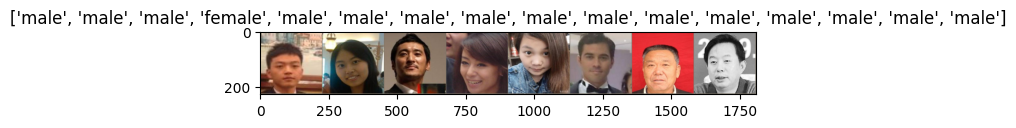

[Test] Loss: 0.6526 Acc: 73.6529% Time: 18.9311s
[Test] Male Accuracy: 97.9398%
[Test] Female Accuracy: 49.3661%


In [ ]:
# Test Phase
# Define a function to display images
def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
    

    # import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import shutil
from tqdm import tqdm
import time


# Define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
# Load the model weights
model.load_state_dict(torch.load('classification_model.pth', map_location=device))
# Move the model to the device
model.to(device)
model.eval()  # Set the model to evaluation mode

# Now the model is ready for inference
aaf_dataset_path = "./gender_classification_dataset_asia"
# these are the paths to the training, validation, and test folders

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# create a new folder for the balanced test set
balanced_test_folder = os.path.join(aaf_dataset_path, "Test_balanced")
balanced_test_dataset = ImageFolder(balanced_test_folder, transform=transforms_val)

# Create DataLoader for the balanced test set
batch_size = 16
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
class_names = balanced_test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(balanced_test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            pred_labels = [class_names[x] for x in preds]
            images = torchvision.utils.make_grid(inputs[:8])
            imshow(images.cpu(), title=pred_labels)

    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

    epoch_loss = running_loss / len(balanced_test_dataset)
    epoch_acc = running_corrects / len(balanced_test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                        time.time() - start_time))

    print('[Test] Male Accuracy: {:.4f}%'.format(male_acc))
    print('[Test] Female Accuracy: {:.4f}%'.format(female_acc))

Class names: ['female', 'male']


c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\haohu\AppData\Local\Temp\ipykernel_2192\484756213.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli

Iteration:  1
[Prediction Result Examples]


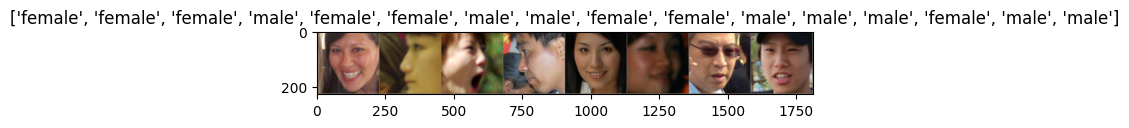

[Test] Loss: 0.4568 Acc: 79.0968% Time: 17.3628s
[Test] Male Accuracy: 79.9228%
[Test] Female Accuracy: 78.2665%
Iteration:  2
[Prediction Result Examples]


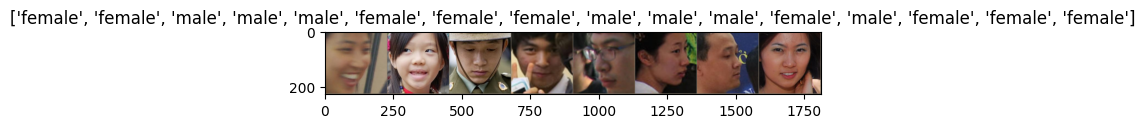

[Test] Loss: 0.7154 Acc: 74.5806% Time: 17.0733s
[Test] Male Accuracy: 63.7066%
[Test] Female Accuracy: 85.5110%
Iteration:  3
[Prediction Result Examples]


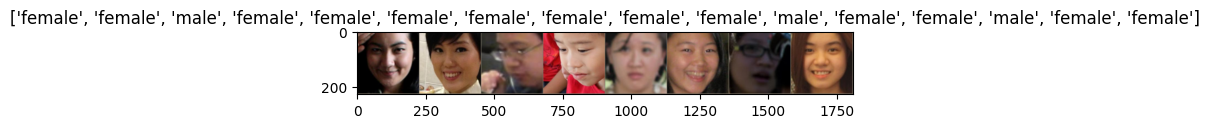

[Test] Loss: 0.8221 Acc: 69.5484% Time: 16.7780s
[Test] Male Accuracy: 49.0347%
[Test] Female Accuracy: 90.1682%
Iteration:  4
[Prediction Result Examples]


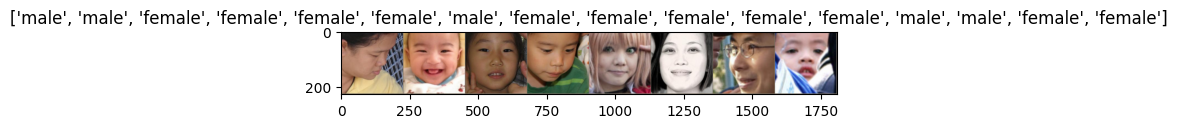

[Test] Loss: 0.8413 Acc: 73.6129% Time: 17.3512s
[Test] Male Accuracy: 61.3900%
[Test] Female Accuracy: 85.8991%
Iteration:  5
[Prediction Result Examples]


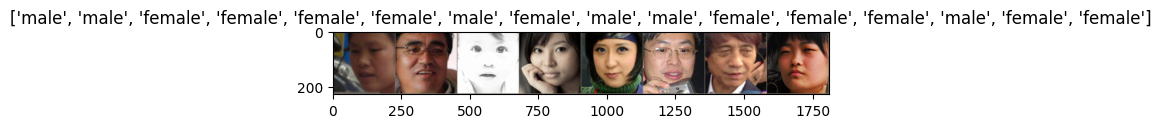

[Test] Loss: 1.1530 Acc: 72.3226% Time: 17.1363s
[Test] Male Accuracy: 56.3707%
[Test] Female Accuracy: 88.3571%
Iteration:  6
[Prediction Result Examples]


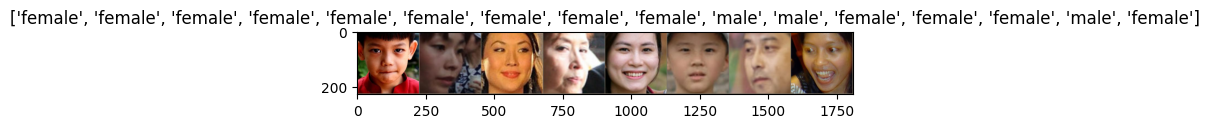

[Test] Loss: 1.2258 Acc: 69.8065% Time: 17.1090s
[Test] Male Accuracy: 49.8069%
[Test] Female Accuracy: 89.9094%
Iteration:  7
[Prediction Result Examples]


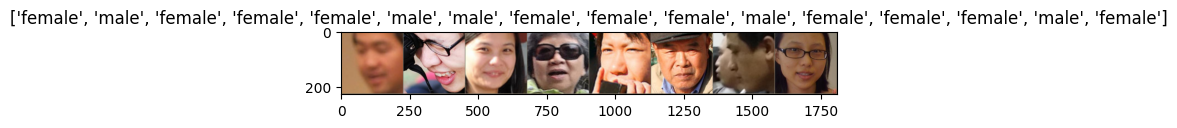

[Test] Loss: 1.4252 Acc: 68.3871% Time: 15.8639s
[Test] Male Accuracy: 45.8172%
[Test] Female Accuracy: 91.0737%
Iteration:  8
[Prediction Result Examples]


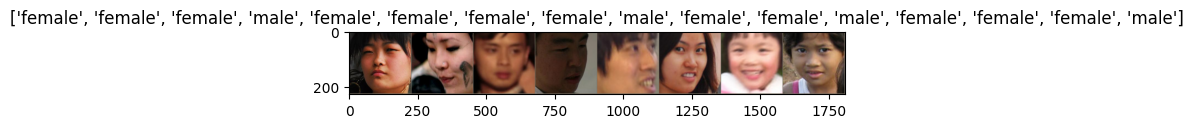

[Test] Loss: 1.3674 Acc: 69.9355% Time: 16.4467s
[Test] Male Accuracy: 51.3514%
[Test] Female Accuracy: 88.6158%
Iteration:  9
[Prediction Result Examples]


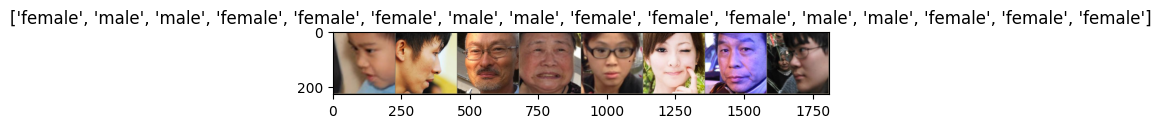

[Test] Loss: 1.5803 Acc: 70.3871% Time: 17.6979s
[Test] Male Accuracy: 52.8958%
[Test] Female Accuracy: 87.9690%
Iteration:  10
[Prediction Result Examples]


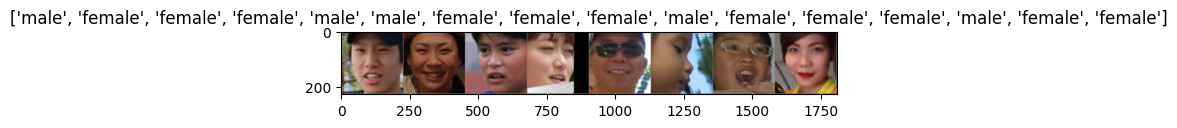

[Test] Loss: 1.5977 Acc: 69.0968% Time: 17.2709s
[Test] Male Accuracy: 49.9356%
[Test] Female Accuracy: 88.3571%
Iteration:  11
[Prediction Result Examples]


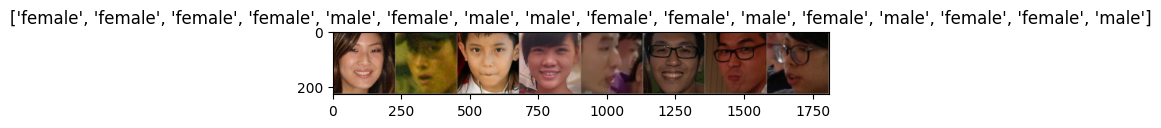

[Test] Loss: 1.5789 Acc: 69.4194% Time: 17.4367s
[Test] Male Accuracy: 51.6088%
[Test] Female Accuracy: 87.3221%
Iteration:  12
[Prediction Result Examples]


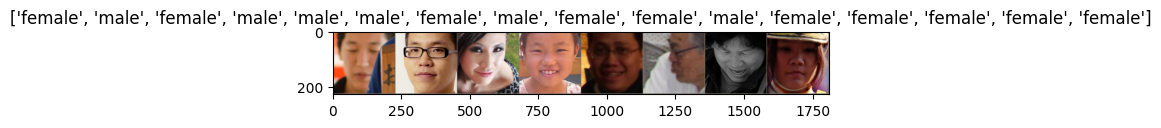

[Test] Loss: 1.6272 Acc: 71.0968% Time: 19.0204s
[Test] Male Accuracy: 55.0837%
[Test] Female Accuracy: 87.1928%
Iteration:  13
[Prediction Result Examples]


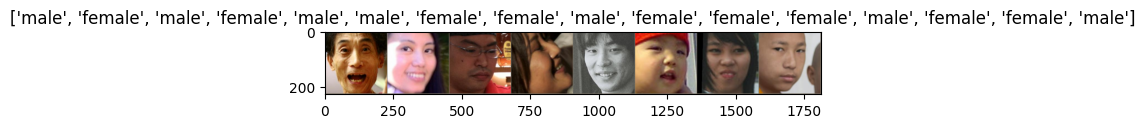

[Test] Loss: 1.8571 Acc: 72.7097% Time: 19.4197s
[Test] Male Accuracy: 60.1030%
[Test] Female Accuracy: 85.3816%
Iteration:  14
[Prediction Result Examples]


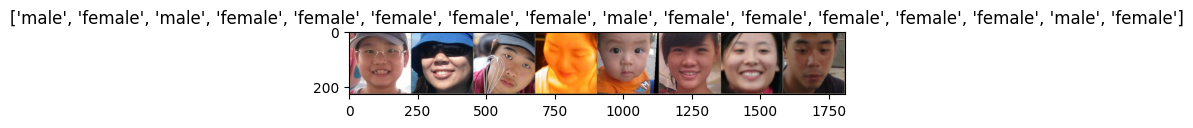

[Test] Loss: 1.7884 Acc: 71.0323% Time: 18.3397s
[Test] Male Accuracy: 53.2819%
[Test] Female Accuracy: 88.8745%
Iteration:  15
[Prediction Result Examples]


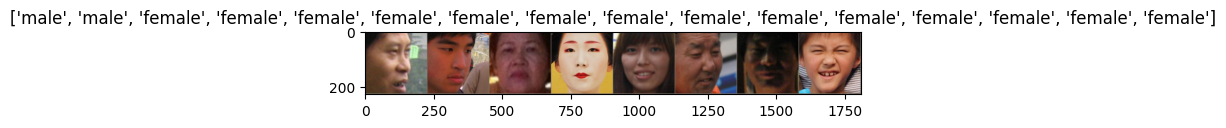

[Test] Loss: 1.9151 Acc: 69.6774% Time: 18.6791s
[Test] Male Accuracy: 50.7079%
[Test] Female Accuracy: 88.7451%
Iteration:  16
[Prediction Result Examples]


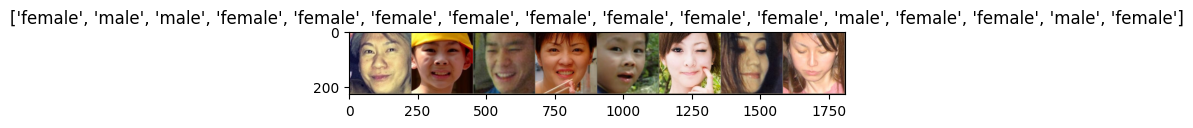

[Test] Loss: 1.9576 Acc: 71.0323% Time: 19.4273s
[Test] Male Accuracy: 54.6976%
[Test] Female Accuracy: 87.4515%
Iteration:  17
[Prediction Result Examples]


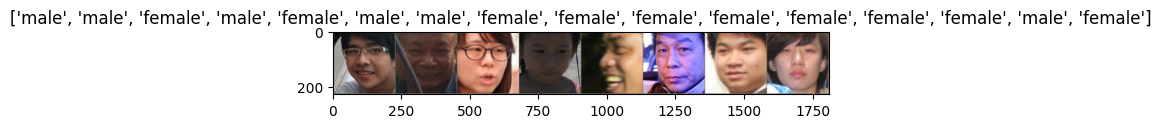

[Test] Loss: 1.6044 Acc: 73.6774% Time: 19.7062s
[Test] Male Accuracy: 61.2613%
[Test] Female Accuracy: 86.1578%
Iteration:  18
[Prediction Result Examples]


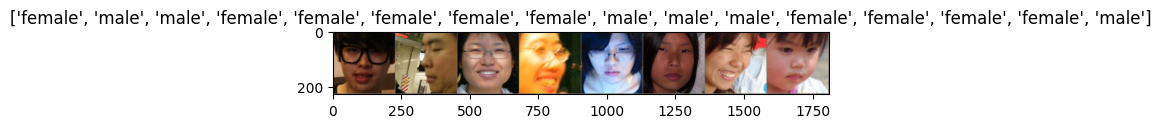

[Test] Loss: 1.8338 Acc: 70.1936% Time: 18.5254s
[Test] Male Accuracy: 51.0940%
[Test] Female Accuracy: 89.3920%
Iteration:  19
[Prediction Result Examples]


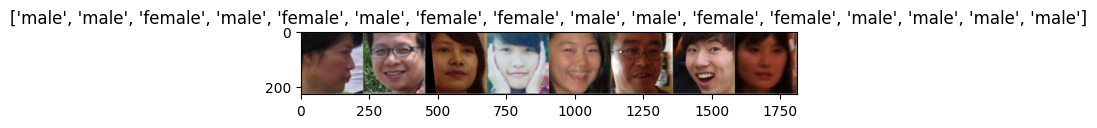

[Test] Loss: 2.0228 Acc: 69.9355% Time: 18.5575s
[Test] Male Accuracy: 50.9653%
[Test] Female Accuracy: 89.0039%
Iteration:  20
[Prediction Result Examples]


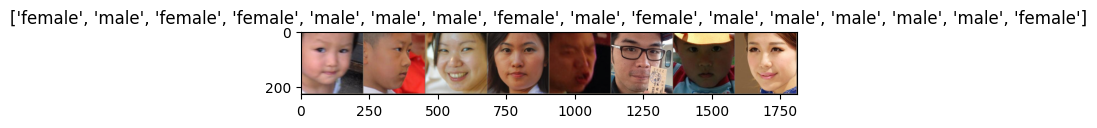

[Test] Loss: 2.3560 Acc: 69.7419% Time: 18.7139s
[Test] Male Accuracy: 50.8366%
[Test] Female Accuracy: 88.7451%


In [3]:
# Test Phase
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aaf_dataset_path = "./fairface_race_dataset"
# Load the model weights
balanced_test_folder = os.path.join(aaf_dataset_path, "East_Asian_Validation") # validation
# balanced_test_folder = os.path.join(aaf_dataset_path, "Balanced_Validation") # test 
# Now the model is ready for inference
batch_size = 16
balanced_test_dataset = ImageFolder(balanced_test_folder, transform=transforms_val)
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

class_names = balanced_test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
results = []
for j in range(1, 21):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dict = torch.load(f'asian_faces_0.6_{j}_balanced_best.pth', map_location=device)
    model.load_state_dict(state_dict)  # strict=False ignores missing layers
    print('Iteration: ', j)
    # Move the model to the device
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    start_time = time.time()

    male_corrects = 0
    male_total = 0
    female_corrects = 0
    female_total = 0

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for i, (inputs, labels) in enumerate(balanced_test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            male_mask = labels == class_names.index('male')
            female_mask = labels == class_names.index('female')

            male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
            male_total += torch.sum(male_mask)

            female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
            female_total += torch.sum(female_mask)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i == 0:
                print('[Prediction Result Examples]')
                pred_labels = [class_names[x] for x in preds]
                images = torchvision.utils.make_grid(inputs[:8])
                imshow(images.cpu(), title=pred_labels)

        male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
        female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

        epoch_loss = running_loss / len(balanced_test_dataset)
        epoch_acc = running_corrects / len(balanced_test_dataset) * 100.
        print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                            time.time() - start_time))
        print('[Test] Male Accuracy: {:.4f}%'.format(male_acc))
        print('[Test] Female Accuracy: {:.4f}%'.format(female_acc))
        # save male, female accuracy and iteration to csv
        results.append([j, epoch_loss, epoch_acc, male_acc.item(), female_acc.item()])

# Save results to CSV
df = pd.DataFrame(results, columns=["Iteration", "Loss", "Accuracy", "Male Accuracy", "Female Accuracy"])
df.to_csv("aaf_0.6_validation_results.csv", index=False)


                   

Class names: ['female', 'male']


c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\haohu\AppData\Local\Temp\ipykernel_2192\1185669437.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

Iteration:  1
[Prediction Result Examples]


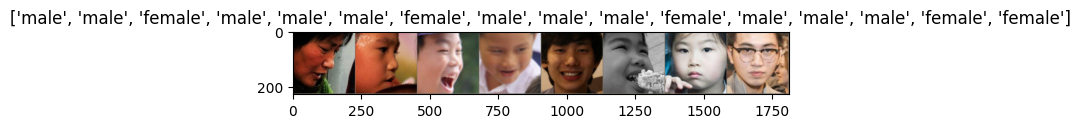

[Validation] Loss: 0.5249 Acc: 77.9355% Time: 20.6281s
[Validation] Male Accuracy: 79.5367%
[Validation] Female Accuracy: 76.3260%
Iteration:  2
[Prediction Result Examples]


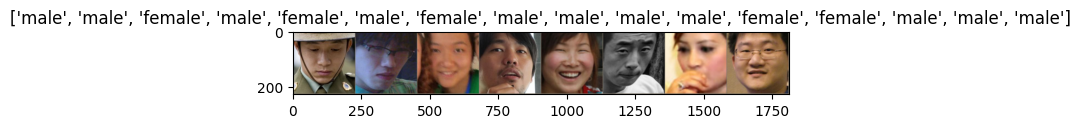

[Validation] Loss: 0.6790 Acc: 76.7742% Time: 18.4212s
[Validation] Male Accuracy: 81.8533%
[Validation] Female Accuracy: 71.6688%
Iteration:  3
[Prediction Result Examples]


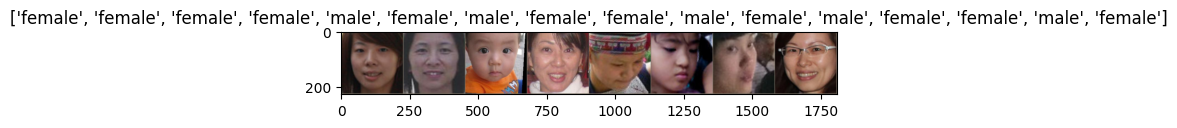

[Validation] Loss: 0.7282 Acc: 77.2903% Time: 18.6534s
[Validation] Male Accuracy: 76.1905%
[Validation] Female Accuracy: 78.3959%
Iteration:  4
[Prediction Result Examples]


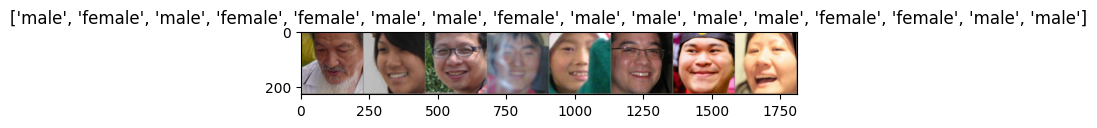

[Validation] Loss: 0.8466 Acc: 76.3871% Time: 18.1499s
[Validation] Male Accuracy: 72.2008%
[Validation] Female Accuracy: 80.5951%
Iteration:  5
[Prediction Result Examples]


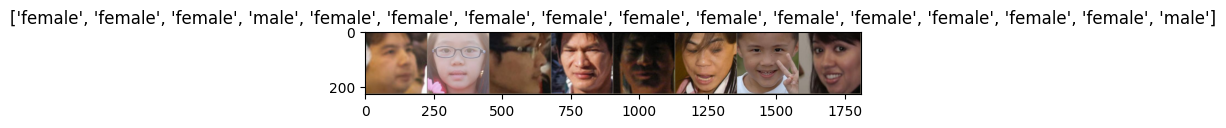

[Validation] Loss: 0.8664 Acc: 75.4194% Time: 19.0718s
[Validation] Male Accuracy: 65.8945%
[Validation] Female Accuracy: 84.9935%
Iteration:  6
[Prediction Result Examples]


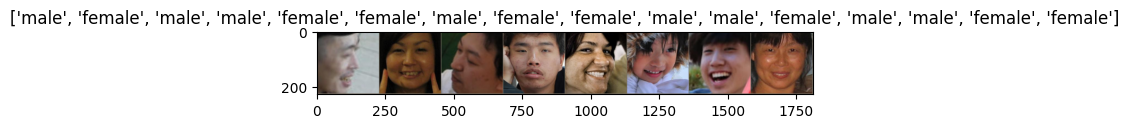

[Validation] Loss: 1.0480 Acc: 75.3548% Time: 25.2186s
[Validation] Male Accuracy: 67.6963%
[Validation] Female Accuracy: 83.0530%
Iteration:  7
[Prediction Result Examples]


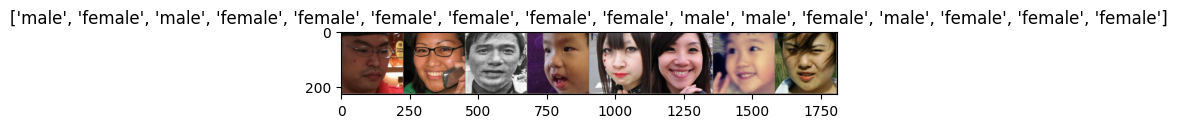

[Validation] Loss: 1.0606 Acc: 74.4516% Time: 27.7794s
[Validation] Male Accuracy: 65.2510%
[Validation] Female Accuracy: 83.6999%
Iteration:  8
[Prediction Result Examples]


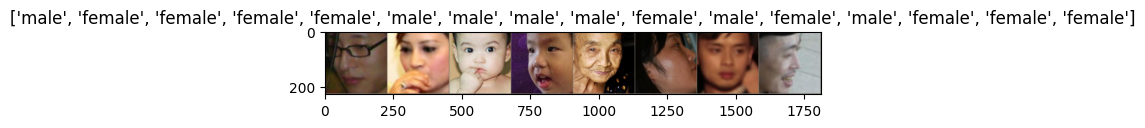

[Validation] Loss: 0.9558 Acc: 76.9677% Time: 17.6492s
[Validation] Male Accuracy: 80.1802%
[Validation] Female Accuracy: 73.7387%
Iteration:  9
[Prediction Result Examples]


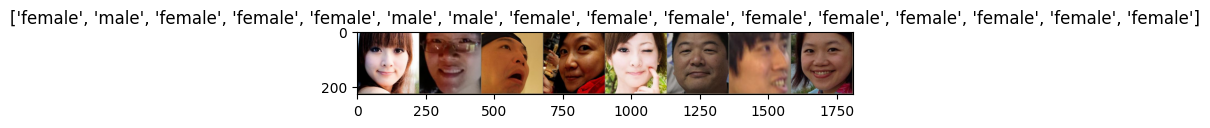

[Validation] Loss: 1.0183 Acc: 75.7419% Time: 18.3516s
[Validation] Male Accuracy: 74.6461%
[Validation] Female Accuracy: 76.8435%
Iteration:  10
[Prediction Result Examples]


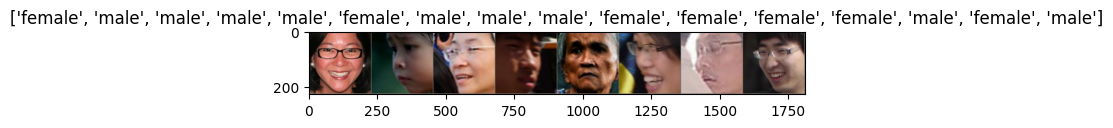

[Validation] Loss: 0.9746 Acc: 75.8710% Time: 17.9953s
[Validation] Male Accuracy: 75.0322%
[Validation] Female Accuracy: 76.7141%
Iteration:  11
[Prediction Result Examples]


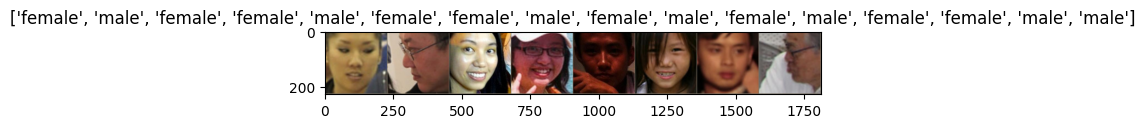

[Validation] Loss: 1.0002 Acc: 75.4839% Time: 17.3387s
[Validation] Male Accuracy: 76.3192%
[Validation] Female Accuracy: 74.6442%
Iteration:  12
[Prediction Result Examples]


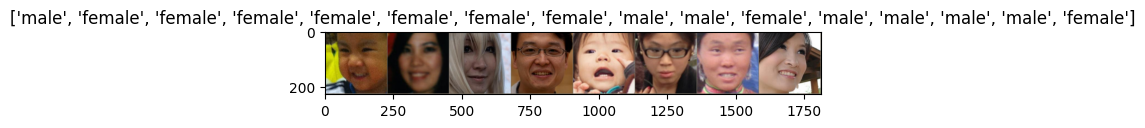

[Validation] Loss: 1.0352 Acc: 74.1290% Time: 19.0445s
[Validation] Male Accuracy: 70.6564%
[Validation] Female Accuracy: 77.6197%
Iteration:  13
[Prediction Result Examples]


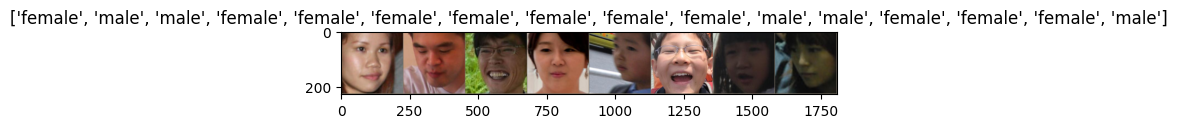

[Validation] Loss: 1.1547 Acc: 75.0968% Time: 28.2672s
[Validation] Male Accuracy: 71.8147%
[Validation] Female Accuracy: 78.3959%
Iteration:  14
[Prediction Result Examples]


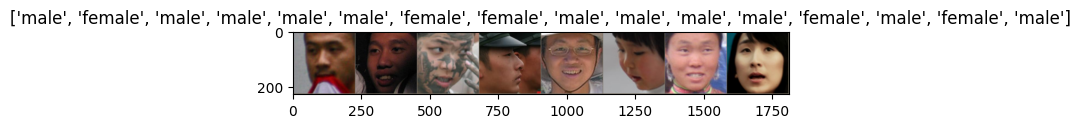

[Validation] Loss: 1.2238 Acc: 75.0968% Time: 28.1539s
[Validation] Male Accuracy: 78.6358%
[Validation] Female Accuracy: 71.5395%
Iteration:  15
[Prediction Result Examples]


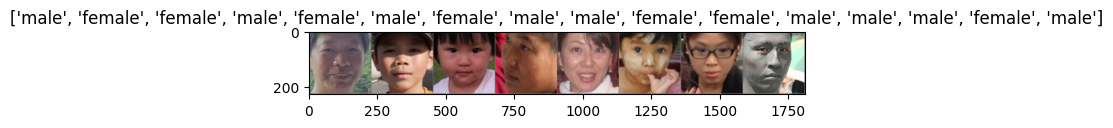

[Validation] Loss: 1.1972 Acc: 76.0645% Time: 45.6672s
[Validation] Male Accuracy: 79.5367%
[Validation] Female Accuracy: 72.5744%
Iteration:  16
[Prediction Result Examples]


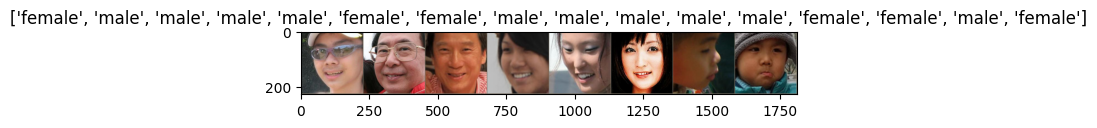

[Validation] Loss: 1.1946 Acc: 76.8387% Time: 39.4473s
[Validation] Male Accuracy: 79.6654%
[Validation] Female Accuracy: 73.9974%
Iteration:  17
[Prediction Result Examples]


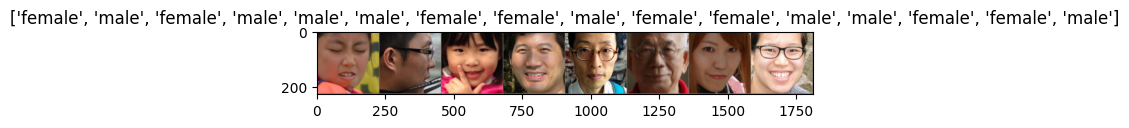

[Validation] Loss: 1.1827 Acc: 76.3226% Time: 39.7105s
[Validation] Male Accuracy: 83.2690%
[Validation] Female Accuracy: 69.3402%
Iteration:  18
[Prediction Result Examples]


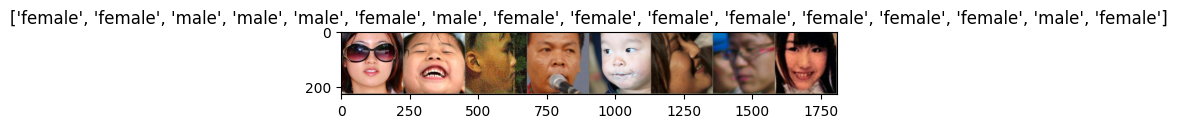

[Validation] Loss: 1.2969 Acc: 76.3871% Time: 54.1213s
[Validation] Male Accuracy: 73.2304%
[Validation] Female Accuracy: 79.5602%
Iteration:  19
[Prediction Result Examples]


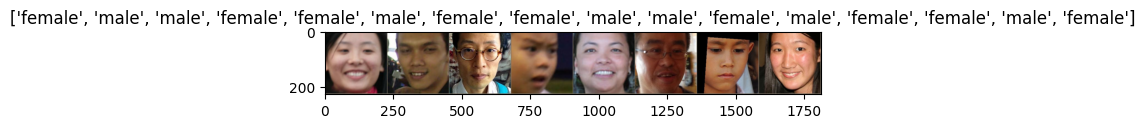

[Validation] Loss: 1.3009 Acc: 75.8065% Time: 41.6022s
[Validation] Male Accuracy: 69.7555%
[Validation] Female Accuracy: 81.8887%
Iteration:  20
[Prediction Result Examples]


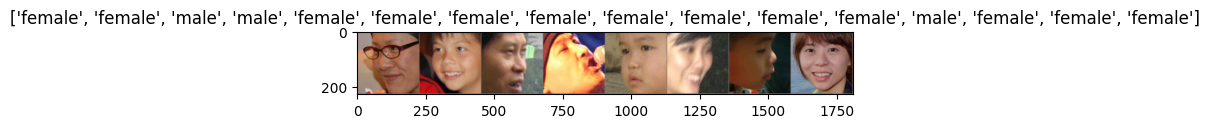

[Validation] Loss: 1.5494 Acc: 75.6129% Time: 44.0235s
[Validation] Male Accuracy: 68.0824%
[Validation] Female Accuracy: 83.1824%


In [4]:
# Test Phase
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aaf_dataset_path = "./fairface_race_dataset"
# Load the model weights
balanced_test_folder = os.path.join(aaf_dataset_path, "East_Asian_Validation") # this is the East Asian Validation dataset

# Now the model is ready for inference
batch_size = 16
balanced_test_dataset = ImageFolder(balanced_test_folder, transform=transforms_val)
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

class_names = balanced_test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
results = []
for j in range(1, 21):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dict = torch.load(f'asian_faces_0.9_{j}_balanced_best.pth', map_location=device)
    model.load_state_dict(state_dict)  # strict=False ignores missing layers
    print('Iteration: ', j)
    # Move the model to the device
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    start_time = time.time()

    male_corrects = 0
    male_total = 0
    female_corrects = 0
    female_total = 0

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for i, (inputs, labels) in enumerate(balanced_test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            male_mask = labels == class_names.index('male')
            female_mask = labels == class_names.index('female')

            male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
            male_total += torch.sum(male_mask)

            female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
            female_total += torch.sum(female_mask)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i == 0:
                print('[Prediction Result Examples]')
                pred_labels = [class_names[x] for x in preds]
                images = torchvision.utils.make_grid(inputs[:8])
                imshow(images.cpu(), title=pred_labels)

        male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
        female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

        epoch_loss = running_loss / len(balanced_test_dataset)
        epoch_acc = running_corrects / len(balanced_test_dataset) * 100.
        print('[Validation] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                            time.time() - start_time))
        print('[Validation] Male Accuracy: {:.4f}%'.format(male_acc))
        print('[Validation] Female Accuracy: {:.4f}%'.format(female_acc))
        # save male, female accuracy and iteration to csv
        results.append([j, epoch_loss, epoch_acc, male_acc.item(), female_acc.item()])

# Save results to CSV
df = pd.DataFrame(results, columns=["Iteration", "Loss", "Accuracy", "Male Accuracy", "Female Accuracy"])
df.to_csv("aaf_0.9_validation_results.csv", index=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

# Function to display images
def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title)
    plt.show()

# Define the validation transform
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the dataset path
aaf_dataset_path = "./fairface_race_dataset"

# List of races to evaluate
races = ["White", "Black", "Latino_Hispanic", "East Asian", "Southeast Asian", "Indian", "Middle Eastern"]

# List of models to evaluate
models_to_evaluate = [
    "classification_model.pth",
    "../5epoch_fairface_5epoch_mixed.pth",
    "../5epoch_fairface.pth"
]
# Add models with dynamic names
for i in range(1, 21):
    models_to_evaluate.append(f"asian_faces_0.9_{i}_balanced_best.pth")
    models_to_evaluate.append(f"asian_faces_0.6_{i}_balanced_best.pth")

# Function to evaluate a model on a dataset
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    male_corrects = 0
    male_total = 0
    female_corrects = 0
    female_total = 0
    running_loss = 0.0
    running_corrects = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            male_mask = labels == class_names.index('male')
            female_mask = labels == class_names.index('female')

            male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
            male_total += torch.sum(male_mask)

            female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
            female_total += torch.sum(female_mask)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
    female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset) * 100.

    return epoch_loss, epoch_acc, male_acc.item(), female_acc.item()

# Main script
results = []

for race in races:
    race_folder = os.path.join(aaf_dataset_path, f"Validation_By_Races/{race}")
    if not os.path.exists(race_folder):
        print(f"Warning: {race_folder} does not exist. Skipping...")
        continue

    # Load the dataset
    race_dataset = ImageFolder(race_folder, transform=transforms_val)
    race_dataloader = DataLoader(race_dataset, batch_size=16, shuffle=True, num_workers=4)
    class_names = race_dataset.classes

    for model_name in models_to_evaluate:
        if not os.path.exists(model_name):
            print(f"Warning: {model_name} does not exist. Skipping...")
            continue

        print(f"Evaluating {model_name} on {race}...")

        # Load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
        state_dict = torch.load(model_name, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)

        # Evaluate the model
        loss, acc, male_acc, female_acc = evaluate_model(model, race_dataloader, class_names, device)

        # Save results
        results.append([race, model_name, loss, acc, male_acc, female_acc])

# Save results to CSV
df = pd.DataFrame(results, columns=["Race", "Model", "Loss", "Accuracy", "Male Accuracy", "Female Accuracy"])
# add to existing csv file
df.to_csv("all_races_validation_results.csv", mode='a', header=False, index=False)


Evaluating classification_model.pth on Middle Eastern...


c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\haohu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\haohu\AppData\Local\Temp\ipykernel_17356\787324786.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

Evaluating ../5epoch_fairface_5epoch_mixed.pth on Middle Eastern...
Evaluating ../5epoch_fairface.pth on Middle Eastern...
Evaluating asian_faces_0.9_1_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.6_1_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.9_2_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.6_2_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.9_3_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.6_3_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.9_4_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.6_4_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.9_5_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.6_5_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.9_6_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.6_6_balanced_best.pth on Middle Eastern...
Evaluating asian_faces_0.9_7_balanced_best.pth on Middle East

Class names: ['female', 'male']


C:\Users\haohu\AppData\Local\Temp\ipykernel_17356\2471920658.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('classification_model.pth', map_loc

[Prediction Result Examples]


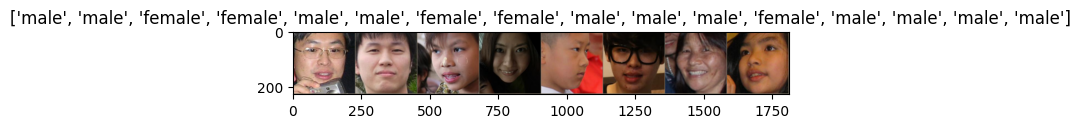

[Validation] Loss: 0.4813 Acc: 77.9355% Time: 22.0490s
[Validation] Male Accuracy: 85.9717%
[Validation] Female Accuracy: 69.8577%


In [2]:
# Test Phase
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aaf_dataset_path = "./fairface_race_dataset"
# Load the model weights
balanced_test_folder = os.path.join(aaf_dataset_path, "East_Asian_Validation") # this is the East Asian Validation dataset
# balanced_test_folder = os.path.join(aaf_dataset_path, "Balanced_Validation")
# Now the model is ready for inference
batch_size = 16
balanced_test_dataset = ImageFolder(balanced_test_folder, transform=transforms_val)
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

class_names = balanced_test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load('classification_model.pth', map_location=device)
model.load_state_dict(state_dict)  # strict=False ignores missing layers
# Move the model to the device
model.to(device)
model.eval()  # Set the model to evaluation mode

start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(balanced_test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            pred_labels = [class_names[x] for x in preds]
            images = torchvision.utils.make_grid(inputs[:8])
            imshow(images.cpu(), title=pred_labels)

male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

epoch_loss = running_loss / len(balanced_test_dataset)
epoch_acc = running_corrects / len(balanced_test_dataset) * 100.
print('[Validation] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                    time.time() - start_time))
print('[Validation] Male Accuracy: {:.4f}%'.format(male_acc))
print('[Validation] Female Accuracy: {:.4f}%'.format(female_acc))
# save male, female accuracy and iteration to csv
results.append([epoch_loss, epoch_acc, male_acc.item(), female_acc.item()])

# Save results to CSV
df = pd.DataFrame(results, columns=["Loss", "Accuracy", "Male Accuracy", "Female Accuracy"])
df.to_csv("baseline-model_validation_results.csv", index=False)

Class names: ['female', 'male']


C:\Users\haohu\AppData\Local\Temp\ipykernel_9016\2383735254.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('../5epoch_fairface.pth', map_locati

[Prediction Result Examples]


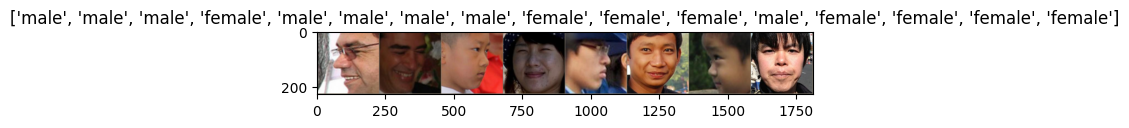

[Validation] Loss: 0.1771 Acc: 92.7094% Time: 35.2499s
[Validation] Male Accuracy: 93.5954%
[Validation] Female Accuracy: 91.6900%


In [25]:
# Test Phase
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

def imshow(input, title):
    # Convert torch.Tensor to numpy array
    input = input.numpy().transpose((1, 2, 0))
    # Undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # Display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aaf_dataset_path = "./fairface_race_dataset"
# Load the model weights
# balanced_test_folder = os.path.join(aaf_dataset_path, "East_Asian_Validation") # this is the East Asian Validation dataset
balanced_test_folder = os.path.join(aaf_dataset_path, "Balanced_Validation")
# Now the model is ready for inference
batch_size = 16
balanced_test_dataset = ImageFolder(balanced_test_folder, transform=transforms_val)
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

class_names = balanced_test_dataset.classes
print('Class names:', class_names)
criterion = nn.CrossEntropyLoss()
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load('../5epoch_fairface.pth', map_location=device)
model.load_state_dict(state_dict)  # strict=False ignores missing layers
# Move the model to the device
model.to(device)
model.eval()  # Set the model to evaluation mode

start_time = time.time()

male_corrects = 0
male_total = 0
female_corrects = 0
female_total = 0

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(balanced_test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        male_mask = labels == class_names.index('male')
        female_mask = labels == class_names.index('female')

        male_corrects += torch.sum(preds[male_mask] == labels[male_mask])
        male_total += torch.sum(male_mask)

        female_corrects += torch.sum(preds[female_mask] == labels[female_mask])
        female_total += torch.sum(female_mask)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            pred_labels = [class_names[x] for x in preds]
            images = torchvision.utils.make_grid(inputs[:8])
            imshow(images.cpu(), title=pred_labels)

male_acc = male_corrects.double() / male_total * 100. if male_total > 0 else 0
female_acc = female_corrects.double() / female_total * 100. if female_total > 0 else 0

epoch_loss = running_loss / len(balanced_test_dataset)
epoch_acc = running_corrects / len(balanced_test_dataset) * 100.
print('[Validation] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc,
                                                                    time.time() - start_time))
print('[Validation] Male Accuracy: {:.4f}%'.format(male_acc))
print('[Validation] Female Accuracy: {:.4f}%'.format(female_acc))
# save male, female accuracy and iteration to csv
results.append([epoch_loss, epoch_acc, male_acc.item(), female_acc.item()])

# Save results to CSV
df = pd.DataFrame(results, columns=["Loss", "Accuracy", "Male Accuracy", "Female Accuracy"])
df.to_csv("fine-tuned-model_test_results.csv", index=False)